## Homework #5. Exploratory Data Analysis
#### Author: `DARIIA KOLODIAZHNA`
#### Total time spent on h/w (in minutes): `...`


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import langdetect
from langdetect import detect
import time
import datetime
import numpy as np
import os
import simplemma
from simplemma import text_lemmatizer
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import sys

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

In [3]:
DIALOGS_MERGED_DATA_PATH = "D:/Dasha/CSS/data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "D:/Dasha/CSS/data/merged_data/dialogs_users_all.csv"
DIALOGS_META_MERGED_DATA_PATH_NEW = "D:/Dasha/CSS/data/merged_data/dialogs_users_all_new.csv"

MERGED_DATA_PATH = "D:\Dasha\CSS\data\merged_data"

In [4]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH, low_memory=False)
df_meta_new = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH_NEW, low_memory=False)



C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Merged table:**

In [5]:
df_all = pd.merge(df,
...               df_meta_new,
...               how='left',
...               left_on=['dialog_id'],
...               right_on=['dialog_id'])
df_all = df_all.rename({'type_x': 'mes_type', 'type_y': 'dialog_type'}, axis=1)


In [6]:
%reload_ext rpy2.ipython

Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [7]:
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.1.3' #path to your R installation
os.environ['R_USER'] = 'C:\\Users\Dasha\anaconda3\envs\myrandpy\Lib\site-packages\rpy2\robjects\lib' 
os.environ['R_LIBS_USER']='C:\\Users\Dasha\Documents\R\win-library\4.1'

In [8]:
%%R
.libPaths( c( "C:/Users/Dasha/Documents/R/win-library/4.1" , .libPaths() ) )
.libPaths()


[1] "C:/Users/Dasha/Documents/R/win-library/4.1"
[2] "C:/Program Files/R/R-4.1.3/library"        


##  Preparation of data

In [6]:
df_all.message =  df_all.message.fillna('')
#df_all['date'] =  df_all.date.apply(lambda x: pd.to_datetime(x))
# df_all['month'] =  df_all.date.apply(lambda x: x.month)
# df_all['day'] =  df_all.date.apply(lambda x: x.day)
# df_all['hour'] =  df_all.date.apply(lambda x: x.hour) df_all['minute'] = df_all.date.apply(lambda x: x.minute)
# df_all['second'] = df_all.date.apply(lambda x: x.second)
df_all['msg_len'] = df_all['message'].apply(lambda x: len(x))
df_all['word_count'] = df_all['message'].apply(lambda x: len(x.split(' ')))
df_all['word_len'] = df_all['message'].apply(lambda x: [len(word) for word in x.split(' ')])
df_all['avg_word_len'] = df_all['word_len'].apply(lambda x: sum(x)/len(x)) 

In [7]:
display(df_all)

,id,date,from_id,to_id,fwd_from,message,mes_type,duration,dialog_id,name,dialog_type,users,msg_len,word_count,word_len,avg_word_len
0,938,2022-02-19 21:18:44+00:00,NaN,PeerChannel(channel_id=1004562718),NaN,Как не надо просить помощи? Нельзя упрекать и ...,text,NaN,-1001004562718,Эволюция,Channel,[],623,93,"[3, 2, 4, 7, 7, 6, 8, 1, 10, 1, 5, 8, 6, 8, 1,...",5.709677
1,937,2022-02-19 19:00:23+00:00,NaN,PeerChannel(channel_id=1004562718),NaN,Конфликт в Украине \n\nЕсли посмотреть на этот...,text,NaN,-1001004562718,Эволюция,Channel,[],2550,390,"[8, 1, 7, 6, 10, 2, 4, 8, 1, 5, 6, 12, 2, 5, 8...",5.541026
2,936,2022-02-19 15:33:49+00:00,NaN,PeerChannel(channel_id=1004562718),NaN,"Теперь такой вопрос, чем отличается ситуация ""...",text,NaN,-1001004562718,Эволюция,Channel,[],719,119,"[6, 5, 7, 3, 10, 8, 8, 1, 5, 7, 2, 9, 5, 4, 4,...",5.050420
3,935,2022-02-19 12:04:44+00:00,NaN,PeerChannel(channel_id=1004562718),NaN,Пока вы пробуете ответить на вопрос в предыдущ...,text,NaN,-1001004562718,Эволюция,Channel,[],1376,222,"[4, 2, 8, 8, 2, 6, 1, 10, 11, 1, 5, 13, 5, 7, ...",5.202703
4,934,2022-02-19 11:25:24+00:00,NaN,PeerChannel(channel_id=1004562718),NaN,"Во всех задачах, которые я предлагаю решать, р...",text,NaN,-1001004562718,Эволюция,Channel,[],2287,323,"[2, 4, 8, 7, 1, 9, 7, 4, 4, 2, 5, 1, 3, 2, 11,...",6.083591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999843,517360,2021-11-19 15:50:06+00:00,NaN,395158213,NaN,Привіт! Я — помічник проєкту Дія. Зі мною ви з...,text,NaN,985334078,Дія – Державні послуги онлайн,Private dialog,"[{'user_id': 985334078, 'first_name': 'Дія – Д...",792,121,"[7, 1, 1, 8, 7, 4, 2, 4, 2, 7, 8, 9, 1, 4, 4, ...",5.553719
1999844,517359,2021-11-19 15:50:05+00:00,PeerUser(user_id=395158213),985334078,NaN,/start,text,NaN,985334078,Дія – Державні послуги онлайн,Private dialog,"[{'user_id': 985334078, 'first_name': 'Дія – Д...",6,1,[6],6.000000
1999845,121118,2019-10-21 13:21:36+00:00,NaN,395158213,NaN,https://t.me/joinchat/H71CY0Ueg1_w2zW5i-3Vng,text,NaN,989904932,Визуал Наповал - бот,Private dialog,"[{'user_id': 989904932, 'first_name': 'Визуал ...",44,1,[44],44.000000
1999846,121117,2019-10-21 13:21:32+00:00,NaN,395158213,NaN,"Привет, участник марафона!\n\nНажми на кнопку,...",text,NaN,989904932,Визуал Наповал - бот,Private dialog,"[{'user_id': 989904932, 'first_name': 'Визуал ...",65,9,"[7, 8, 16, 2, 7, 5, 7, 1, 4]",6.333333


In [10]:
users=df_meta_new.get('users')


In [11]:
df_array = []
for  d in users:
 
    d= d.replace("'", "\"").replace("\\", "\\\\")
    json_acceptable_string = d.replace("None", "null")

    local_df = pd.read_json(json_acceptable_string, encoding="utf8")
    df_array.append(local_df)
    
all_us = pd.concat(df_array, ignore_index=True)
all_us=all_us.drop_duplicates()

In [12]:
users=users.drop([41])

***List of all users for merging:***

In [13]:
all_us.reindex()
display(all_us)

,user_id,first_name,last_name,username,phone
0,478427920,Лиза,None,lizussshka,3.806743e+11
1,342667961,Юля Вербик,None,VerbikYullya,3.806644e+11
2,334976382,Dmytro,Novykov,gfmmcin,3.806749e+11
3,286207770,Машвщ Фгн,None,mariarudi,3.809811e+11
4,374120991,None,None,ahahanchos,3.806743e+11
...,...,...,...,...,...
10020,967572663,Ника,🍋,stafa88,3.809394e+11
10021,981873825,i.love.my.cycle,NaN,iLoveMyCycleBot,NaN
10022,982705034,L’Oréal Casting Creme Gloss,NaN,Loreal_Casting_Creme_Gloss_bot,NaN
10023,983000232,Quiz Bot,NaN,QuizBot,NaN


## Step 2.  Group analysis

### Some stats from KMA chats

#### Creating a list with most likely KMA students

In [14]:
moh_stud=df_meta[df_meta["name"].str.contains("Філіал КМЦ|Примати20х2",na=False)].get("users")
moh_stud=moh_stud.unique().tolist()
for r in moh_stud:
    if  "395158213" in r:
        moh_stud.remove(r) #remove myself from the list 


In [15]:
def is_KMAStudent(user):
    if user in moh_stud:
        return True
    return False

In [16]:
groups=df_meta[df_meta["type"]=="Group"]

groups['isKMASt']=groups["users"].apply(is_KMAStudent)
groups["size"]=0


C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Creating a dataset of chats with Mohyla's students:



In [17]:
moh_gr = []
all_gr=[]
gr=groups.groupby(["dialog_id", "name"],as_index=False).agg( moh_student=('isKMASt', sum), size=("size", "size"))
for index, row in gr.iterrows():
    all_gr.append(row)
    if row['moh_student']!=0 and row['size']/row['moh_student']<2:
        row.values.tolist()
        moh_gr.append(row)
KMA_gr = pd.DataFrame(moh_gr)
all_gr=pd.DataFrame(all_gr)



## 1. How many  Mohyla students are in each chat?

In [18]:
KMA_gr["perc"]=(KMA_gr["moh_student"]/KMA_gr['size'])*100    
all_gr["perc"]=( all_gr["moh_student"]/all_gr['size'])*100 
all_gr.loc[all_gr['perc'].isnull(), 'perc'] = 0


In [162]:
all_gr


,name,moh_student,size,perc
38,Філіал КМЦ,2753,2754,99.963689
25,Примати20х2,44,45,97.777778
21,Колоквіум,38,39,97.435897
42,Диференціальні рівняння ПМ-2,37,38,97.368421
69,"Математичний аналіз, ПМ-2",37,39,94.871795
...,...,...,...,...
74,"Отдых отдыхом, а Старварин не Артем🗿",0,3,0.000000
23,Команда «Кексики»,0,8,0.000000
76,Культурно обогощаемся🍷,0,3,0.000000
48,Новый сменовский год🥳,0,9,0.000000


In [20]:
all_gr =all_gr.drop('dialog_id', axis=1)

In [21]:
all_gr=all_gr.sort_values("perc", ascending=False)

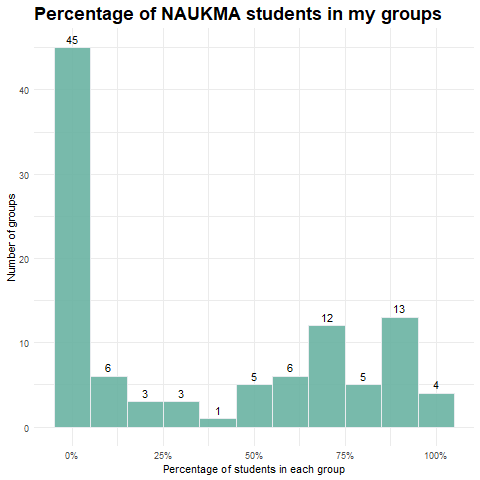

In [161]:
%%R -i all_gr
library(tidyverse)
library(hrbrthemes)


# plot
p <- all_gr %>%
  ggplot( aes(x=perc)) +
    geom_histogram( binwidth=10, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
    labs(y='Number of groups', x="Percentage of students in each group", title = "Percentage of NAUKMA students in my groups") + 
    scale_x_continuous(labels = function(x) paste0(x, "%"))+

    stat_bin(binwidth=10, geom="text", aes(label=..count..), vjust=-0.5)+
    theme(plot.title = element_text(size = 18, face = "bold"))
ggsave("perc.png", width = 10, height = 8)

p

## 2.	What language of communication predominates (Ukranian / Russian) in these chats


    
    
    

In [25]:
KMA_dialogs = pd.merge(df,
...               KMA_gr,
...               left_on=['dialog_id'],
...               right_on=['dialog_id'])
KMAtext=KMA_dialogs[(KMA_dialogs["type"]=="text") & (df["type"].notnull())]

C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [26]:
def detection(x):
    try:
        return detect(str(x))
    except:
        return 0

In [27]:

KMAtext["lang"]   = KMAtext["message"].apply(lambda x: detection(x))


In [47]:

def format_date(date):
  return (datetime.datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S+00:00").date())

In [81]:
KMAtext.date = KMAtext.date.apply(format_date)


In [46]:
KMAtext["date"]=pd.to_datetime(KMAtext["date"])
KMAtext["date"]=KMAtext["date"].dt.to_period('M')


In [8]:
#KMAtext.to_csv(f"{MERGED_DATA_PATH}/KMAdialogs_data_with_lang_perM.csv", index=False)
KMAtext=pd.read_csv(f"{MERGED_DATA_PATH}/KMAdialogs_data_with_lang_perM.csv")

In [32]:
size=KMAtext.groupby(["date"]).size().reset_index(name="amount")

uk=KMAtext[(KMAtext["lang"]=="uk")].groupby("date").size().reset_index(name="uk")
ru=KMAtext[(KMAtext["lang"]=="ru")].groupby("date").size().reset_index(name="ru")
en=KMAtext[(KMAtext["lang"]=="en")].groupby("date").size().reset_index(name="en")


In [21]:
KMAtext.groupby("date").size()

date
2018-10      466
2018-11      650
2018-12      757
2019-01      928
2019-02      815
2019-03      164
2019-04      190
2019-05      207
2019-06      377
2019-07      840
2019-08      864
2019-09     1406
2019-10     1417
2019-11     1014
2019-12      954
2020-01      405
2020-02      605
2020-03      642
2020-04       75
2020-05      102
2020-06       56
2020-07       23
2020-08    47524
2020-09    51017
2020-10    41550
2020-11    37763
2020-12    46201
2021-01    20173
2021-02     7129
2021-03     8232
2021-04    10628
2021-05     8139
2021-06     8178
2021-07     4369
2021-08     7310
2021-09    20959
2021-10    15778
2021-11    18465
2021-12    16329
2022-01    20435
2022-02    19616
dtype: int64

In [ ]:
size=size.merge(uk, on="date",how ='left').merge(ru, on="date",how ='left').merge(en, on="date",how ='left')
size = size.replace(np.nan, 0)
size[['uk','ru', 'en']]=size[['uk','ru', 'en']].div(size.amount, axis=0)


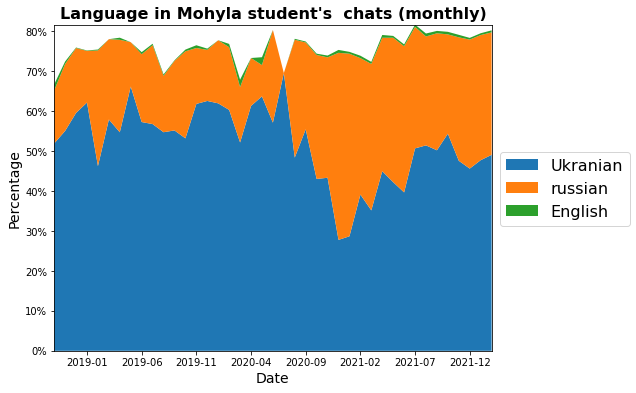

In [44]:
 import matplotlib.ticker as mtick 
x = np.arange(0,len(size),1)
fig, ax = plt.subplots(1,1,  figsize=(9, 6))
ax.stackplot(size['date'],size['uk'],size['ru'], size['en'])
plt.title("Language in Mohyla student's  chats (monthly)", fontsize = 16, fontweight ='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 5),fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.margins(0,0)
fig.subplots_adjust(right=0.8)

ax.legend(['Ukranian', 'russian', 'English'], prop={"size":16},
    loc="center left",
    bbox_to_anchor=(0.8, 0.5),
    bbox_transform=fig.transFigure)
plt.show()


## 3. How is the session period different from the usual one? TCP from the usual?



In [48]:
KMA_dialogs.date=KMA_dialogs.date.apply(format_date)


In [49]:
from datetime import date 
stsr =datetime.date.fromisoformat('2021-10-18')
ftsr = date.fromisoformat('2021-10-24')
tsr=KMA_dialogs[(KMA_dialogs["date"]>= stsr)& (KMA_dialogs['date'] <= ftsr)].reset_index(drop=True)

sexams = date.fromisoformat('2021-12-13')
fexams = date.fromisoformat('2021-12-19')
exams=KMA_dialogs[(KMA_dialogs["date"]>= sexams)& (KMA_dialogs['date'] <= fexams)].reset_index(drop=True)

sus =datetime.date.fromisoformat('2021-11-08')
fus = datetime.date.fromisoformat('2021-11-14')
usual=KMA_dialogs[(KMA_dialogs["date"]>= sus)& (KMA_dialogs['date'] <= fus)].reset_index(drop=True)



In [50]:

stsr = date.fromisoformat('2021-02-27')
ftsr = date.fromisoformat('2021-03-05')
tsr1=KMA_dialogs[(KMA_dialogs["date"]>= stsr)& (KMA_dialogs['date'] <= ftsr)].reset_index(drop=True)

sexams = date.fromisoformat('2021-04-17')
fexams = date.fromisoformat('2021-04-25')
exams1=KMA_dialogs[(KMA_dialogs["date"]>= sexams)& (KMA_dialogs['date'] <= fexams)].reset_index(drop=True)

sus = date.fromisoformat('2021-03-13')
fus = date.fromisoformat('2021-03-19')
usual1=KMA_dialogs[(KMA_dialogs["date"]>= sus)& (KMA_dialogs['date'] <= fus)].reset_index(drop=True)



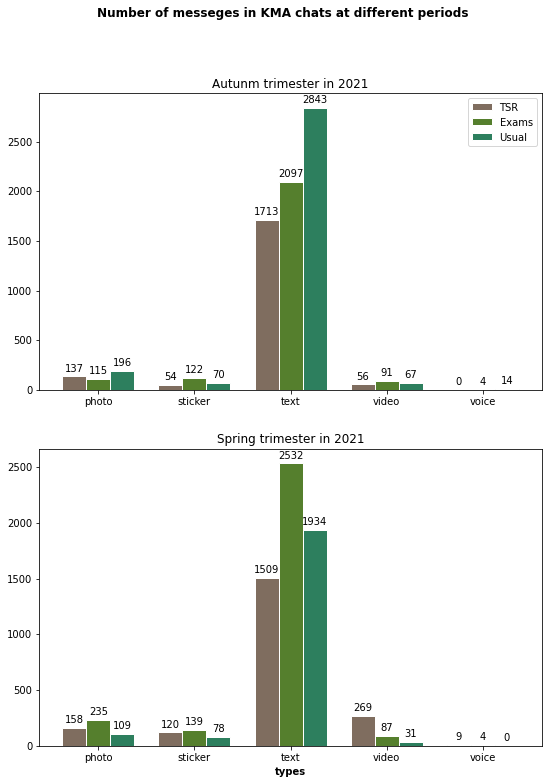

In [51]:
labels=usual.groupby(['type']).size().index

tsr_s=tsr.groupby(['type']).size().values
tsr_s=np.append(tsr_s, [0])
ex_s=exams.groupby(['type']).size().values
us_s=usual.groupby(['type']).size().values

tsr_s1=tsr1.groupby(['type']).size().values
ex_s1=exams1.groupby(['type']).size().values
us_s1=usual1.groupby(['type']).size().values
us_s1=np.append(us_s1, [0])

barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(us_s))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


fig, ax = plt.subplots(2,1,  figsize=(9, 12))
b1=ax[0].bar(r1, tsr_s, color='#7f6d5f', width=barWidth, edgecolor='white', label='TSR')
b2=ax[0].bar(r2, ex_s, color='#557f2d', width=barWidth, edgecolor='white', label='Exams')
b3=ax[0].bar(r3, us_s, color='#2d7f5e', width=barWidth, edgecolor='white', label='Usual')
        
plt.xticks([r + barWidth for r in range(len(tsr_s))], labels)

ax[0].bar_label(b1, padding=3)
ax[0].bar_label(b2, padding=3)
ax[0].bar_label(b3, padding=3)

plt.sca(ax[0])
plt.xticks([r + barWidth for r in range(len(tsr_s))], labels)
ax[0].set_title("Autunm trimester in 2021")

b4=ax[1].bar(r1, tsr_s1, color='#7f6d5f', width=barWidth, edgecolor='white', label='TSR')
b5=ax[1].bar(r2, ex_s1, color='#557f2d', width=barWidth, edgecolor='white', label='Exams')
b6=ax[1].bar(r3, us_s1, color='#2d7f5e', width=barWidth, edgecolor='white', label='Usual')

plt.legend()
ax[1].set_title("Spring trimester in 2021")
ax[1].set_xlabel('types', fontweight='bold')


ax[1].bar_label(b4, padding=3)
ax[1].bar_label(b5, padding=3)
ax[1].bar_label(b6, padding=3)

fig.suptitle('Number of messeges in KMA chats at different periods', fontweight='bold')
plt.show()



## A bit of textmining

In [52]:
text = df[(df["type"]=="text")].dropna(how='all')
onlytext = text[['message','dialog_id', 'date']]

In [54]:
s=df_meta.groupby(["dialog_id","name"]).size().reset_index(name="size")
s = s.drop('size', 1)


C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [55]:
onlytext=pd.merge(onlytext,
...               s,
                  how='left',
...               left_on=['dialog_id'],
...               right_on=['dialog_id'])

In [56]:
corpus=onlytext[onlytext["name"].str.contains("Філіал КМЦ|Абітурієнт КПІ|СБУ|KMA Random Coffee Chat|Ты нормааальний вообщеее?|Примати20х2",na=False)]

In [57]:
corpus=corpus.drop("dialog_id", 1)


C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [58]:
corpus=corpus.dropna()


In [60]:
#Create lemmatizer and stopwords list
#lemmatizer = LemmatizerModel.pretrained("lemma", "uk").setInputCols(Array("token")).setOutputCol("lemma")
ru_stopwords = nltk.corpus.stopwords.words("russian")
ua_stopwords={'а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї', 'абичиїй', 'абичиїм', 'абичиїми', 'абичиїх', 'абичого', 'абичому', 'абищо', 'абияка', 'абияке', 'абиякий', 'абияким', 'абиякими', 'абияких', 'абиякого', 'абиякому', 'абиякою', 'абиякої', 'абияку', 'абиякі', 'абиякій', 'абиякім', 'або', 'абощо', 'авжеж', 'авось', 'ага', 'ад', 'адже', 'аж', 'ажень', 'аз', 'ай', 'але', 'ало', 'амінь', 'ант', 'ану', 'ані', 'аніде', 'аніж', 'анізащо', 'аніким', 'анікого', 'анікогісінько', 'аніколи', 'анікому', 'аніскільки', 'аніхто', 'анічим', 'анічого', 'анічогісінько', 'анічому', 'аніщо', 'аніяка', 'аніяке', 'аніякий', 'аніяким', 'аніякими', 'аніяких', 'аніякого', 'аніякому', 'аніякою', 'аніякої', 'аніяку', 'аніякі', 'аніякій', 'аніякім', 'аніякісенька', 'аніякісеньке', 'аніякісенький', 'аніякісеньким', 'аніякісенькими', 'аніякісеньких', 'аніякісенького', 'аніякісенькому', 'аніякісенькою', 'аніякісенької', 'аніякісеньку', 'аніякісенькі', 'аніякісенькій', 'аніякісенькім', 'аніякісінька', 'аніякісіньке', 'аніякісінький', 'аніякісіньким', 'аніякісінькими', 'аніякісіньких', 'аніякісінького', 'аніякісінькому', 'аніякісінькою', 'аніякісінької', 'аніякісіньку', 'аніякісінькі', 'аніякісінькій', 'аніякісінькім', 'ат', 'ато', 'атож', 'ау', 'ах', 'ач', 'ачей', 'аякже', 'б', 'ба', 'багато', 'багатьма', 'багатьом', 'багатьох', 'баз', 'бай', 'бат', 'бах', 'бац', 'баш', 'бе', 'беж', 'без', 'безперервно', 'бел', 'бер', 'би', 'бир', 'бич', 'близько', 'близько від', 'бо', 'бов', 'бод', 'бодай', 'боз', 'бош', 'був', 'буває', 'буде', 'будем', 'будемо', 'будете', 'будеш', 'буду', 'будуть', 'будь', 'будь ласка', 'будьмо', 'будьте', 'була', 'були', 'було', 'бути', 'бух', 'буц', 'буцім', 'буцімто', 'бі', 'біб', 'більш', 'більше', 'біля', 'в', 'в бік', 'в залежності від', 'в міру', 'в напрямі до', 'в порівнянні з', 'в процесі', 'в результаті', 'в ролі', 'в силу', 'в сторону', 'в супроводі', 'в ході', "в ім'я", 'в інтересах', 'вад', 'важлива', 'важливе', 'важливий', 'важливі', 'вак', 'вам', 'вами', 'ван', 'вас', 'ват', 'ваш', 'ваша', 'ваше', 'вашим', 'вашими', 'ваших', 'вашого', 'вашому', 'вашою', 'вашої', 'вашу', 'ваші', 'вашій', 'вашім', 'ввесь', 'вві', 'вгору', 'вдалині', 'вед', 'верх', 'весь', 'вех', 'вже', 'вздовж', 'ви', 'виз', 'вис', 'височині', 'вище ', 'вйо', 'власне', 'властиво', 'вміти', 'внаслідок', 'вниз', 'внизу', 'во', 'вон', 'вона', 'вони', 'воно', 'восьмий', 'вперед', 'вподовж', 'впоперек', 'впритиск', 'впритул', 'впродовж', 'впрост', 'все', 'всередині', 'всею', 'вслід', 'всупереч', 'всього', 'всьому', 'всю', 'всюди', 'вся', 'всяк', 'всяка', 'всяке', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякому', 'всякою', 'всякої', 'всяку', 'всякі', 'всякій', 'всякім', 'всі', 'всій', 'всіляка', 'всіляке', 'всілякий', 'всіляким', 'всілякими', 'всіляких', 'всілякого', 'всілякому', 'всілякою', 'всілякої', 'всіляку', 'всілякі', 'всілякій', 'всілякім', 'всім', 'всіма', 'всіх', 'всією', 'всієї', 'втім', 'ві', 'віг', 'від', 'від імені', 'віддалік від', 'відколи', 'відносно', 'відповідно', 'відповідно до', 'відсотків', 'відтепер', 'відтоді', 'він', 'вісім', 'вісімнадцятий', 'вісімнадцять', 'віт', 'віф', 'віх', 'віц', 'віщо', 'віщось', 'г', 'га', 'гав', 'гаразд', 'ге', 'гез', 'гем', 'геп', 'гет', 'геть', 'гех', 'ги', 'гик', 'гир', 'гич', 'гм', 'го', 'говорив', 'гог', 'гоп', 'гоц', 'гу', 'гуп', 'д', 'да', 'давай', 'давати', 'давно', 'далеко', 'далеко від', 'далі', 'даром', 'два', 'двадцятий', 'двадцять', 'дванадцятий', 'дванадцять', 'двох', 'дві', 'де', "дев'ятий", "дев'ятнадцятий", "дев'ятнадцять", "дев'ять", 'дедалі', 'деким', 'декого', 'деколи', 'декому', 'декотра', 'декотре', 'декотрий', 'декотрим', 'декотрими', 'декотрих', 'декотрого', 'декотрому', 'декотрою', 'декотрої', 'декотру', 'декотрі', 'декотрій', 'декотрім', 'декілька', 'декільком', 'декількома', 'декількох', 'декім', 'десь', 'десятий', 'десять', 'дехто', 'дечий', 'дечийого', 'дечийому', 'дечим', 'дечию', 'дечия', 'дечиє', 'дечиєму', 'дечиєю', 'дечиєї', 'дечиї', 'дечиїй', 'дечиїм', 'дечиїми', 'дечиїх', 'дечого', 'дечому', 'дечім', 'дещо', 'деяка', 'деяке', 'деякий', 'деяким', 'деякими', 'деяких', 'деякого', 'деякому', 'деякою', 'деякої', 'деяку', 'деякі', 'деякій', 'деякім', 'деінде', 'для', 'до', 'добре', 'довго', 'довкола', 'довкіл', 'дог', 'доки', 'допоки', 'допіру', 'досить', 'досі', 'дотепер', 'доти', 'другий', 'друго', 'дуже', 'дякую', 'дійсно', 'діл', 'е', 'еге', 'еж', 'ей', 'ерг', 'ест', 'ет', 'ех', 'еч', 'ж', 'же', 'жоден', 'жодна', 'жодне', 'жодний', 'жодним', 'жодними', 'жодних', 'жодного', 'жодному', 'жодною', 'жодної', 'жодну', 'жодні', 'жодній', 'жоднім', 'жоднісінька', 'жоднісіньке', 'жоднісінький', 'жоднісіньким', 'жоднісінькими', 'жоднісіньких', 'жоднісінького', 'жоднісінькому', 'жоднісінькою', 'жоднісінької', 'жоднісіньку', 'жоднісінькі', 'жоднісінькій', 'жоднісінькім', 'жуз', 'з', 'з метою', 'з нагоди', 'з приводу', 'з розрахунку на', 'з-за', 'з-над', 'з-перед', 'з-поза', 'з-поміж', 'з-понад', 'з-поперед', 'з-посеред', 'з-проміж', 'з-під', 'з-серед', 'за', 'за винятком', 'за допомогою', 'за посередництвом', 'за рахунок', 'завгодно', 'завдяки', 'завжди', 'завше', 'задля', 'зазвичай', 'зайнята', 'зайнятий', 'зайнято', 'зайняті', 'залежно', 'залежно від', 'замість', 'занадто', 'заради', 'зараз', 'зас', 'зате', 'збоку', 'збоку від', 'зважаючи на', 'зверх ', 'зверху', 'звичайно', 'звиш', 'звідки', 'звідкилясь', 'звідкись', 'звідкіль', 'звідкіля', 'звідкілясь', 'звідси', 'звідсіль', 'звідсіля', 'звідти', 'звідтіль', 'звідтіля', 'звідусюди', 'звідусіль', 'звідціля', 'згідно з', 'здається', 'здовж', 'зем', 'зет', 'ззаду', 'зиз', 'зик', 'значить', 'знову', 'зо', 'зовсім', 'зсередини', 'зух', 'зі', 'зіс', 'и', 'ич', 'й', 'ймовірно', 'йно', 'йо', 'його', 'йой', 'йол', 'йому', 'йор', 'йот', 'site' ,'set-0', 'showlot','ukma''йох', 'к', 'каже', 'каз', 'кар', 'каф', 'ках', 'ке', 'кед', 'кет', 'кеш', 'кив', 'кий', 'кил', 'ким', 'кимось', 'кимсь', 'ких', 'киш', 'коб', 'коби', 'кого', 'когось', 'кожен', 'кожна', 'кожне', 'кожний', 'кожним', 'кожними', 'кожних', 'кожного', 'кожному', 'кожною', 'кожної', 'кожну', 'кожні', 'кожній', 'кожнім', 'кожнісінька', 'кожнісіньке', 'кожнісінький', 'кожнісіньким', 'кожнісінькими', 'кожнісіньких', 'кожнісінького', 'кожнісінькому', 'кожнісінькою', 'кожнісінької', 'кожнісіньку', 'кожнісінькі', 'кожнісінькій', 'кожнісінькім', 'коли', 'колись', 'коло', 'кому', 'комусь', 'котра', 'котрась', 'котре', 'котресь', 'котрий', 'котрийсь', 'котрим', 'котрими', 'котримись', 'котримось', 'котримсь', 'котрих', 'котрихось', 'котрихсь', 'котрого', 'котрогось', 'котрому', 'котромусь', 'котрою', 'котроюсь', 'котрої', 'котроїсь', 'котру', 'котрусь', 'котрі', 'котрій', 'котрійсь', 'котрім', 'котрімсь', 'котрісь', 'коц', 'коч', 'коштом', 'край', 'краще', 'кру', 'круг', 'кругом', 'крю', 'кря', 'крізь', 'крім', 'куди', 'кудись', 'кудою', 'кілька', 'кільком', 'кількома', 'кількох', 'кім', 'кімось', 'кімсь', 'кінець', 'л', 'лаж', 'лап', 'лас', 'лат', 'ле', 'ледве', 'ледь', 'лет', 'лиш', 'лише', 'лишень', 'лум', 'луп', 'лут', 'льє', 'люди', 'людина', 'ля', 'лі', 'ліворуч від', 'лік', 'лім', 'м', 'мабуть', 'майже', 'мало', 'мати', 'мац', 'ме', 'меж', 'мене', 'менше', 'мені', 'мерсі', 'мет', 'мжа', 'ми', 'мимо ', 'миру', 'мит', 'мною', 'мо', 'мов', 'мовби', 'мовбито', 'могла', 'могли', 'могло', 'мого', 'могти', 'мож', 'може', 'можем', 'можемо', 'можете', 'можеш', 'можна', 'можу', 'можуть', 'можіть', 'мой', 'мол', 'мою', 'моя', 'моє', 'моєму', 'моєю', 'моєї', 'мої', 'моїй', 'моїм', 'моїми', 'моїх', 'му', 'мі', 'міг', 'між', 'мій', 'мільйонів', 'н', 'на', 'на адресу', 'на базі', 'на благо', 'на випадок', 'на відміну від', 'на засадах', 'на знак', 'на зразок', 'на користь', 'на кшталт', 'на межі', 'на основі', 'на противагу', 'на підставі', 'на честь', 'на чолі', 'на ґрунті', 'навколо', 'навкруг', 'навкруги ', 'навкіл', 'навпаки', 'навперейми', 'навпроти', 'навіть', 'навіщо', 'навіщось', 'нагорі', 'над', 'надо', 'надовкола', 'надокола', 'наді', 'назавжди', 'назад', 'назустріч', 'най', 'найбільш', 'нам', 'нами', 'наоколо ', 'наокруг ', 'наокруги ', 'наокіл', 'наперед', 'напередодні', 'напереді', 'наперекір', 'напереріз', 'наприкінці', 'напроти', 'нарешті', 'нарівні з', 'нас', 'насеред', 'насподі', 'наспід', 'настрічу', 'насупроти', 'насупротив ', 'нате', 'наче', 'начеб', 'начебто', 'наш', 'наша', 'наше', 'нашим', 'нашими', 'наших', 'нашого', 'нашому', 'нашою', 'нашої', 'нашу', 'наші', 'нашій', 'нашім', 'не', 'не до', 'не можна', 'неабичим', 'неабичого', 'неабичому', 'неабищо', 'небагато', 'небагатьма', 'небагатьом', 'небагатьох', 'небудь', 'невважаючи', 'невже', 'недалеко', 'недалеко від', 'неж', 'незалежно від', 'незважаючи', 'незважаючи на', 'ней', 'немає', 'немов', 'немовби', 'немовбито', 'неначе', 'неначебто', 'неподалеку', 'неподалеку від', 'неподалечку', 'неподалечку від', 'неподалік', 'неподалік від', 'нерідко', 'нех', 'нехай', 'нещодавно', 'нею', 'неї', 'нижче', 'низько', 'ник', 'ним', 'ними', 'них', 'нич', 'но', 'ну', 'нуг', 'нуд', 'нум', 'нумо', 'нумте', 'ньо', 'нього', 'ньому', 'ню', 'нюх', 'ня', 'няв', 'ні', 'ніби', 'ніби-то', 'нібито', 'ніде', 'ніж', 'нізащо', 'нізвідки', 'нізвідкіля', 'ній', 'ніким', 'нікого', 'нікогісінько', 'ніколи', 'нікому', 'нікотра', 'нікотре', 'нікотрий', 'нікотрим', 'нікотрими', 'нікотрих', 'нікотрого', 'нікотрому', 'нікотрою', 'нікотрої', 'нікотру', 'нікотрі', 'нікотрій', 'нікотрім', 'нікуди', 'нім', 'нінащо', 'ніскільки', 'ніт', 'ніхто', 'нічий', 'нічийна', 'нічийне', 'нічийний', 'нічийним', 'нічийними', 'нічийних', 'нічийного', 'нічийному', 'нічийною', 'нічийної', 'нічийну', 'нічийні', 'нічийній', 'нічийнім', 'нічийого', 'нічийому', 'нічим', 'нічию', 'нічия', 'нічиє', 'нічиєму', 'нічиєю', 'нічиєї', 'нічиї', 'нічиїй', 'нічиїм', 'нічиїми', 'нічиїх', 'нічого', 'нічому', 'ніщо', 'ніяк', 'ніяка', 'ніяке', 'ніякий', 'ніяким', 'ніякими', 'ніяких', 'ніякого', 'ніякому', 'ніякою', 'ніякої', 'ніяку', 'ніякі', 'ніякій', 'ніякім', 'ніякісінька', 'ніякісіньке', 'ніякісінький', 'ніякісіньким', 'ніякісінькими', 'ніякісіньких', 'ніякісінького', 'ніякісінькому', 'ніякісінькою', 'ніякісінької', 'ніякісіньку', 'ніякісінькі', 'ніякісінькій', 'ніякісінькім', 'о', 'об', 'обабіч', 'обаполи', 'обидва', 'обр', 'обік', 'обіруч', 'обіч', 'ов', 'од', 'один', 'одинадцятий', 'одинадцять', 'одна', 'однак', 'одначе', 'одне', 'одним', 'одними', 'одних', 'одно', 'одного', 'одного разу', 'одному', 'одною', 'одної', 'одну', 'одні', 'одній', 'однім', 'однією', 'однієї', 'ож', 'ой', 'окрай', 'окроме', 'округ', 'округи', 'окрім', 'окіл', 'ом', 'он', 'онде', 'онно', 'оно', 'оподаль', 'оподаль від', 'оподалік', 'оподалік від', 'опостін', 'опостінь', 'опроче', 'опріч', 'опріче', 'опісля', 'осе', 'оскільки', 'особливо', 'осторонь', 'ось', 'осісьо', 'от', 'ота', 'отак', 'отака', 'отаке', 'отакий', 'отаким', 'отакими', 'отаких', 'отакого', 'отакому', 'отакою', 'отакої', 'отаку', 'отакі', 'отакій', 'отакім', 'отакісінька', 'отакісіньке', 'отакісінький', 'отакісіньким', 'отакісінькими', 'отакісіньких', 'отакісінького', 'отакісінькому', 'отакісінькою', 'отакісінької', 'отакісіньку', 'отакісінькі', 'отакісінькій', 'отакісінькім', 'отам', 'оте', 'отже', 'отим', 'отими', 'отих', 'ото', 'отого', 'отож', 'отой', 'отому', 'отою', 'отої', 'отсе', 'оттак', 'отто', 'оту', 'отут', 'оті', 'отій', 'отім', 'отією', 'отієї', 'ох', 'оце', 'оцей', 'оцим', 'оцими', 'оцих', 'оцього', 'оцьому', 'оцю', 'оця', 'оці', 'оцій', 'оцім', 'оцією', 'оцієї', 'п', "п'я", "п'ятий", "п'ятнадцятий", "п'ятнадцять", "п'ять", 'па', 'пад', 'пак', 'пек', 'перед', 'передо', 'переді', 'перетака', 'перетаке', 'перетакий', 'перетаким', 'перетакими', 'перетаких', 'перетакого', 'перетакому', 'перетакою', 'перетакої', 'перетаку', 'перетакі', 'перетакій', 'перетакім', 'перший', 'пиж', 'плі', 'по', 'поблизу', 'побік', 'побіля', 'побіч', 'поверх', 'повз', 'повздовж', 'повинно', 'повище', 'повсюди', 'повсюдно', 'подаль від', 'подалі від', 'подекуди', 'подеяка', 'подеяке', 'подеякий', 'подеяким', 'подеякими', 'подеяких', 'подеякого', 'подеякому', 'подеякою', 'подеякої', 'подеяку', 'подеякі', 'подеякій', 'подеякім', 'подовж', 'подібно до', 'поз', 'поза', 'позад', 'позаду', 'позата', 'позате', 'позатим', 'позатими', 'позатих', 'позатого', 'позатой', 'позатому', 'позатою', 'позатої', 'позату', 'позаті', 'позатій', 'позатім', 'позатією', 'позатієї', 'позаяк', 'поздовж', 'поки', 'покрай', 'покіль', 'помежи', 'помимо', 'поміж', 'помість', 'понад', 'понадо', 'понаді', 'понижче', 'пообіч', 'поодаль від', 'поодалік від', 'поперед', 'попереду', 'поперек', 'попліч', 'попри', 'попросту', 'попід', 'пора', 'поруч', 'поряд', 'поряд з', 'порівняно з', 'посеред', 'посередині', 'потрібно', 'потім', 'поуз', 'початку', 'почерез', 'праворуч від', 'пред', 'предо', 'преді', 'прекрасно', 'прецінь', 'при', 'притому', 'причому', 'причім', 'про', 'проз', 'промеж', 'проміж', 'просто', 'проте', 'проти', 'против', 'противно', 'протягом', 'пря', 'пріч', 'пхе', 'пху', 'пі', 'пів', 'півперек', 'під', 'під знаком', 'під приводом', 'під час', 'підо', 'пізніше', 'пім', 'пір', 'після', 'р', 'ради', 'раз', 'разом з', 'разу', 'рано', 'раніш', 'раніш від', 'раніше', 'раніше від', 'раптом', 'ре', 'рет', 'риж', 'рим', 'рип', 'роб', 'року', 'років', 'рос', 'рох', 'році', 'рус', 'рух', 'руч', 'рік', 'с', 'саж', 'саз', 'сак', 'сам', 'сама', 'саме', 'сами', 'самий', 'самим', 'самими', 'самих', 'само', 'самого', 'самому', 'самою', 'самої', 'саму', 'самі', 'самій', 'самім', 'сап', 'сас', 'свого', 'свою', 'своя', 'своє', 'своєму', 'своєю', 'своєї', 'свої', 'своїй', 'своїм', 'своїми', 'своїх', 'свій', 'се', 'себе', 'себто', 'сей', 'сен', 'серед', 'середи', 'середу', 'сеч', 'си', 'сив', 'сиг', 'сиз', 'сик', 'сиріч', 'сих', 'сказав', 'сказала', 'сказати', 'скрізь', 'скільки', 'скільки-то', 'скількись', 'скільком', 'скількома', 'скількомась', 'скількомось', 'скількомсь', 'скількох', 'скількохось', 'скількохсь', 'сли', 'слідом за', 'соб', 'собою', 'собі', 'соп', 'спасибі', 'спереду', 'спочатку', 'справ', 'справді', 'став', 'стосовно', 'стільки', 'стільком', 'стількома', 'стількох', 'су', 'судячи з', 'супроти', 'супротив', 'суть', 'суч', 'суш', 'сьогодні', 'сьомий', 'сюди', 'ся', 'сяг', 'сяк', 'сяка', 'сяке', 'сякий', 'сяким', 'сякими', 'сяких', 'сякого', 'сякому', 'сякою', 'сякої', 'сяку', 'сякі', 'сякій', 'сякім', 'сям', 'сі', 'сім', 'сімнадцятий', 'сімнадцять', 'сіп', 'т', 'та', 'таж', 'так', 'така', 'таке', 'такенна', 'такенне', 'такенний', 'такенним', 'такенними', 'такенних', 'такенного', 'такенному', 'такенною', 'такенної', 'такенну', 'такенні', 'такенній', 'такеннім', 'таки', 'такий', 'таким', 'такими', 'таких', 'такого', 'також', 'такому', 'такою', 'такої', 'таку', 'такі', 'такій', 'такім', 'такісінька', 'такісіньке', 'такісінький', 'такісіньким', 'такісінькими', 'такісіньких', 'такісінького', 'такісінькому', 'такісінькою', 'такісінької', 'такісіньку', 'такісінькі', 'такісінькій', 'такісінькім', 'тал', 'там', 'тамки', 'тамта', 'тамте', 'тамтим', 'тамтими', 'тамтих', 'тамтого', 'тамтой', 'тамтому', 'тамтою', 'тамтої', 'тамту', 'тамті', 'тамтій', 'тамтім', 'тамтією', 'тамтієї', 'тар', 'тат', 'таш', 'тва', 'твого', 'твою', 'твоя', 'твоє', 'твоєму', 'твоєю', 'твоєї', 'твої', 'твоїй', 'твоїм', 'твоїми', 'твоїх', 'твій', 'те', 'тебе', 'тег', 'теж', 'тем', 'тепер', 'теперечки', 'тес', 'теф', 'теє', 'ти', 'тик', 'тил', 'тим', 'тими', 'тисяч', 'тих', 'то', 'тобою', 'тобто', 'тобі', 'того', 'тоді', 'тож', 'той', 'тол', 'тому', 'тому що', 'тот', 'тощо', 'тою', 'тої', 'тра', 'тре', 'треба', 'третій', 'три', 'тринадцятий', 'тринадцять', 'трохи', 'тс', 'тсс', 'ту', 'туди', 'тудою', 'туп', 'тут', 'тутеньки', 'тутечки', 'тутки', 'туф', 'туц', 'тю', 'тюг', 'тюп', 'тяг', 'тяж', 'тям', 'тяп', 'ті', 'тій', 'тільки', 'тім', 'тією', 'у', 'у бік', 'у вигляді', 'у випадку', 'у відповідності до', 'у відповідь на', 'у залежності від', "у зв'язку з", 'у міру', 'у напрямі до', 'у порівнянні з', 'у процесі', 'у результаті', 'у ролі', 'у силу', 'у сторону', 'у супроводі', 'у ході', 'ув', 'увесь', 'уві', 'угу', 'уже', 'узбіч', 'уздовж', 'укр', 'ум', 'унаслідок', 'униз', 'унизу', 'унт', 'уперед', 'уподовж', 'упоперек', 'упритиск до', 'упритул до', 'упродовж', 'упрост', 'ус', 'усе', 'усередині', 'услід', 'услід за', 'усупереч', 'усього', 'усьому', 'усю', 'усюди', 'уся', 'усяк', 'усяка', 'усяке', 'усякий', 'усяким', 'усякими', 'усяких', 'усякого', 'усякому', 'усякою', 'усякої', 'усяку', 'усякі', 'усякій', 'усякім', 'усі', 'усій', 'усіляка', 'усіляке', 'усілякий', 'усіляким', 'усілякими', 'усіляких', 'усілякого', 'усілякому', 'усілякою', 'усілякої', 'усіляку', 'усілякі', 'усілякій', 'усілякім', 'усім', 'усіма', 'усіх', 'усією', 'усієї', 'утім', 'ух', 'ф', "ф'ю", 'фа', 'фаг', 'фай', 'фат', 'фе', 'фед', 'фез', 'фес', 'фет', 'фзн', 'фоб', 'фот', 'фра', 'фру', 'фу', 'фук', 'фур', 'фус', 'фіш', 'х', 'ха', 'хаз', 'хай', 'хап', 'хат', 'хащ', 'хе', 'хет', 'хи', 'хиб', 'хм', 'хо', 'хов', 'хол', 'хон', 'хоп', 'хор', 'хотіти', 'хоч', 'хоча', 'хочеш', 'хро', 'хрю', 'хто', 'хтось', 'ху', 'хуз', 'хук', 'хух', 'хху', 'хіба', 'ц', 'це', 'цебто', 'цей', 'цеп', 'ци', 'цим', 'цими', 'цир', 'цих', 'цло', 'цоб', 'цок', 'цоп', 'цор', 'цс', 'цсс', 'цуг', 'цур', 'цуц', 'цього', 'цьому', 'цю', 'цюк', 'ця', 'цяв', 'цяп', 'ці', 'цід', 'цій', 'цім', 'ціною', 'цією', 'цієї', 'ч', 'чал', 'чар', 'час', 'часто', 'частіше', 'часу', 'чах', 'чей', 'чень', 'через', 'четвертий', 'чи', 'чий', 'чийого', 'чийогось', 'чийому', 'чийомусь', 'чийсь', 'чик', 'чим', 'чимось', 'чимсь', 'чир', 'численна', 'численне', 'численний', 'численним', 'численними', 'численних', 'численні', 'чию', 'чиюсь', 'чия', 'чиясь', 'чиє', 'чиєму', 'чиємусь', 'чиєсь', 'чиєю', 'чиєюсь', 'чиєї', 'чиєїсь', 'чиї', 'чиїй', 'чиїйсь', 'чиїм', 'чиїми', 'чиїмись', 'чиїмось', 'чиїмсь', 'чиїсь', 'чиїх', 'чиїхось', 'чиїхсь', 'чля', 'чого', 'чогось', 'чом', 'чому', 'чомусь', 'чон', 'чоп', 'чортзна', 'чос', 'чотири', 'чотирнадцятий', 'чотирнадцять', 'чу', 'чум', 'чур', 'чш', 'чім', 'чімось', 'чімсь', 'чіт', 'ш', 'ша', 'шаг', 'шал', 'шам', 'шво', 'шед', 'шен', 'шиз', 'шир', 'шляхом', 'шостий', 'шістнадцятий', 'шістнадцять', 'шість', 'щ', 'ще', 'щем', 'щеп', 'щип', 'щир', 'що', 'щоб', 'щоби', 'щодо', 'щойно', 'щоправда', 'щось', 'щі', 'ь', 'ю', 'юз', 'юн', 'юнь', 'юс', 'ют', 'юхт', 'я', 'яв', 'яд', 'яз', 'язь', 'як', 'яка', 'якась', 'якби', 'яке', 'якесь', 'який', 'якийсь', 'яким', 'якими', 'якимись', 'якимось', 'якимсь', 'яких', 'якихось', 'якихсь', 'якого', 'якогось', 'якому', 'якомусь', 'якось', 'якою', 'якоюсь', 'якої', 'якоїсь', 'якраз', 'яку', 'якусь', 'якщо', 'які', 'якій', 'якійсь', 'якім', 'якімсь', 'якісь', 'ял', 'ям', 'ян', 'янь', 'яо', 'яп', 'ярл', 'ясь', 'ять', 'є', 'єр', 'єси', 'і', 'ібн', 'ід', 'із', 'із-за', 'із-під', 'іззаду', 'ізм', 'ізсередини', 'ік', 'ікс', 'ікт', "ім'я", 'імовірно', 'інакша', 'інакше', 'інакший', 'інакшим', 'інакшими', 'інакших', 'інакшого', 'інакшому', 'інакшою', 'інакшої', 'інакшу', 'інакші', 'інакшій', 'інакшім', 'інколи', 'іноді', 'інша', 'інше', 'інший', 'іншим', 'іншими', 'інших', 'іншого', 'іншому', 'іншою', 'іншої', 'іншу', 'інші', 'іншій', 'іншім', 'інь', 'іч', 'іще', 'ї', 'їдь', 'їй', 'їм', 'їх', 'їхнього', 'їхньому', 'їхньою', 'їхньої', 'їхню', 'їхня', 'їхнє', 'їхні', 'їхній', 'їхнім', 'їхніми', 'їхніх', 'її', 'ґ'}
my_stopwords=all_us["username"].to_list()
my_stopwords.extend(ua_stopwords)
my_stopwords.extend(ru_stopwords)

from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
#Preprocess function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
#> ['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']

# Lemmatize list of words and join
#tokens = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    #Create lemmatizer and stopwords list
   #  langdata = simplemma.load_data('uk', 'ru', 'en')
   # tokens = text_lemmatizer(text.lower(), langdata)
    tokens = [token for token in tokens if token not in my_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [82]:

corpus['message']=corpus['message'].apply(lambda x: preprocess_text(x) )

In [68]:
display(gp)

,name,message,date
0,KMA Random Coffee Chat,Підписалася❤️ Дякуємо підтримку ❤️ Бігом підпи...,2022-02-19 22:00:59+00:00
1,Абітурієнт КПІ,Закінчується реєстрація Останній день реєстрац...,2022-02-17 13:19:24+00:00
2,Примати20х2,Если захочет Шеву поехать взять направление вы...,2022-02-18 10:14:35+00:00
3,"СБУ ( малюки, братчики, котики та файні спудеї)",Чи обирати правильних патронес знати правильни...,2022-02-19 21:28:19+00:00
4,Ты нормааальний вообщеее?,Эх ладно продолжение тех увидит шедевр завтра ...,2022-02-19 23:59:10+00:00
5,Філіал КМЦ,От зайшло тотальне базування ... А коледжі вик...,2022-02-20 00:58:16+00:00


In [64]:
gp=corpus

In [65]:

gp['message'] = corpus.groupby(['name'])['message'].transform(lambda x : ' '.join(x))
#grouped_corpus.groupby(['name'])['message'].apply(lambda x : ' '.join(x))
#gruped=grouped_corpus[['name', 'message']].groupby('name', as_index=False).agg(' '.join)

In [67]:
gp=gp.groupby('name').first().reset_index()


### tf-idf

In [70]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=0, stop_words= None)
# right
tfidf = tfidf_vectorizer.fit_transform(gp['message'])


In [73]:
tfidf_df = pd.DataFrame(tfidf.toarray(), index=gp["name"], columns=tfidf_vectorizer.get_feature_names())


C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [74]:
tfidf_df=tfidf_df.stack().reset_index()

In [75]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_1': 'term'})


In [76]:
tfidf_df30=tfidf_df.sort_values(by=['name','tfidf'], ascending=[True,False]).groupby(['name']).head(30)



In [159]:
%%R  -i  tfidf_df30
library(dplyr, warn.conflicts = FALSE)
library(forcats)
library(ggplot2)
library(repr)



tfidf_df30 %>%
  group_by(name) %>%
  slice_max(tfidf, n = 15) %>%
  ungroup() %>%
  ggplot(aes(tfidf, fct_reorder(term, tfidf), fill = name)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~name, ncol = 2, scales = "free") +
  labs(x = "tf-idf", y = NULL)
ggsave("tf-idf.jpg", width = 9, height = 15)



## 4. The most popular and unique words in the chats

This result needs improvement: stemmatization and lemmatization. Unfortunately, lemmatization of the Ukrainian text takes too much time and needs to be optimized in the future. Therefore, it was decided to temporarily use this plot.

However, graph still shows that in the "KPI Applicant" people are most interested in certain specialties, the "Filial" discusses policy and national issues, and so on.


 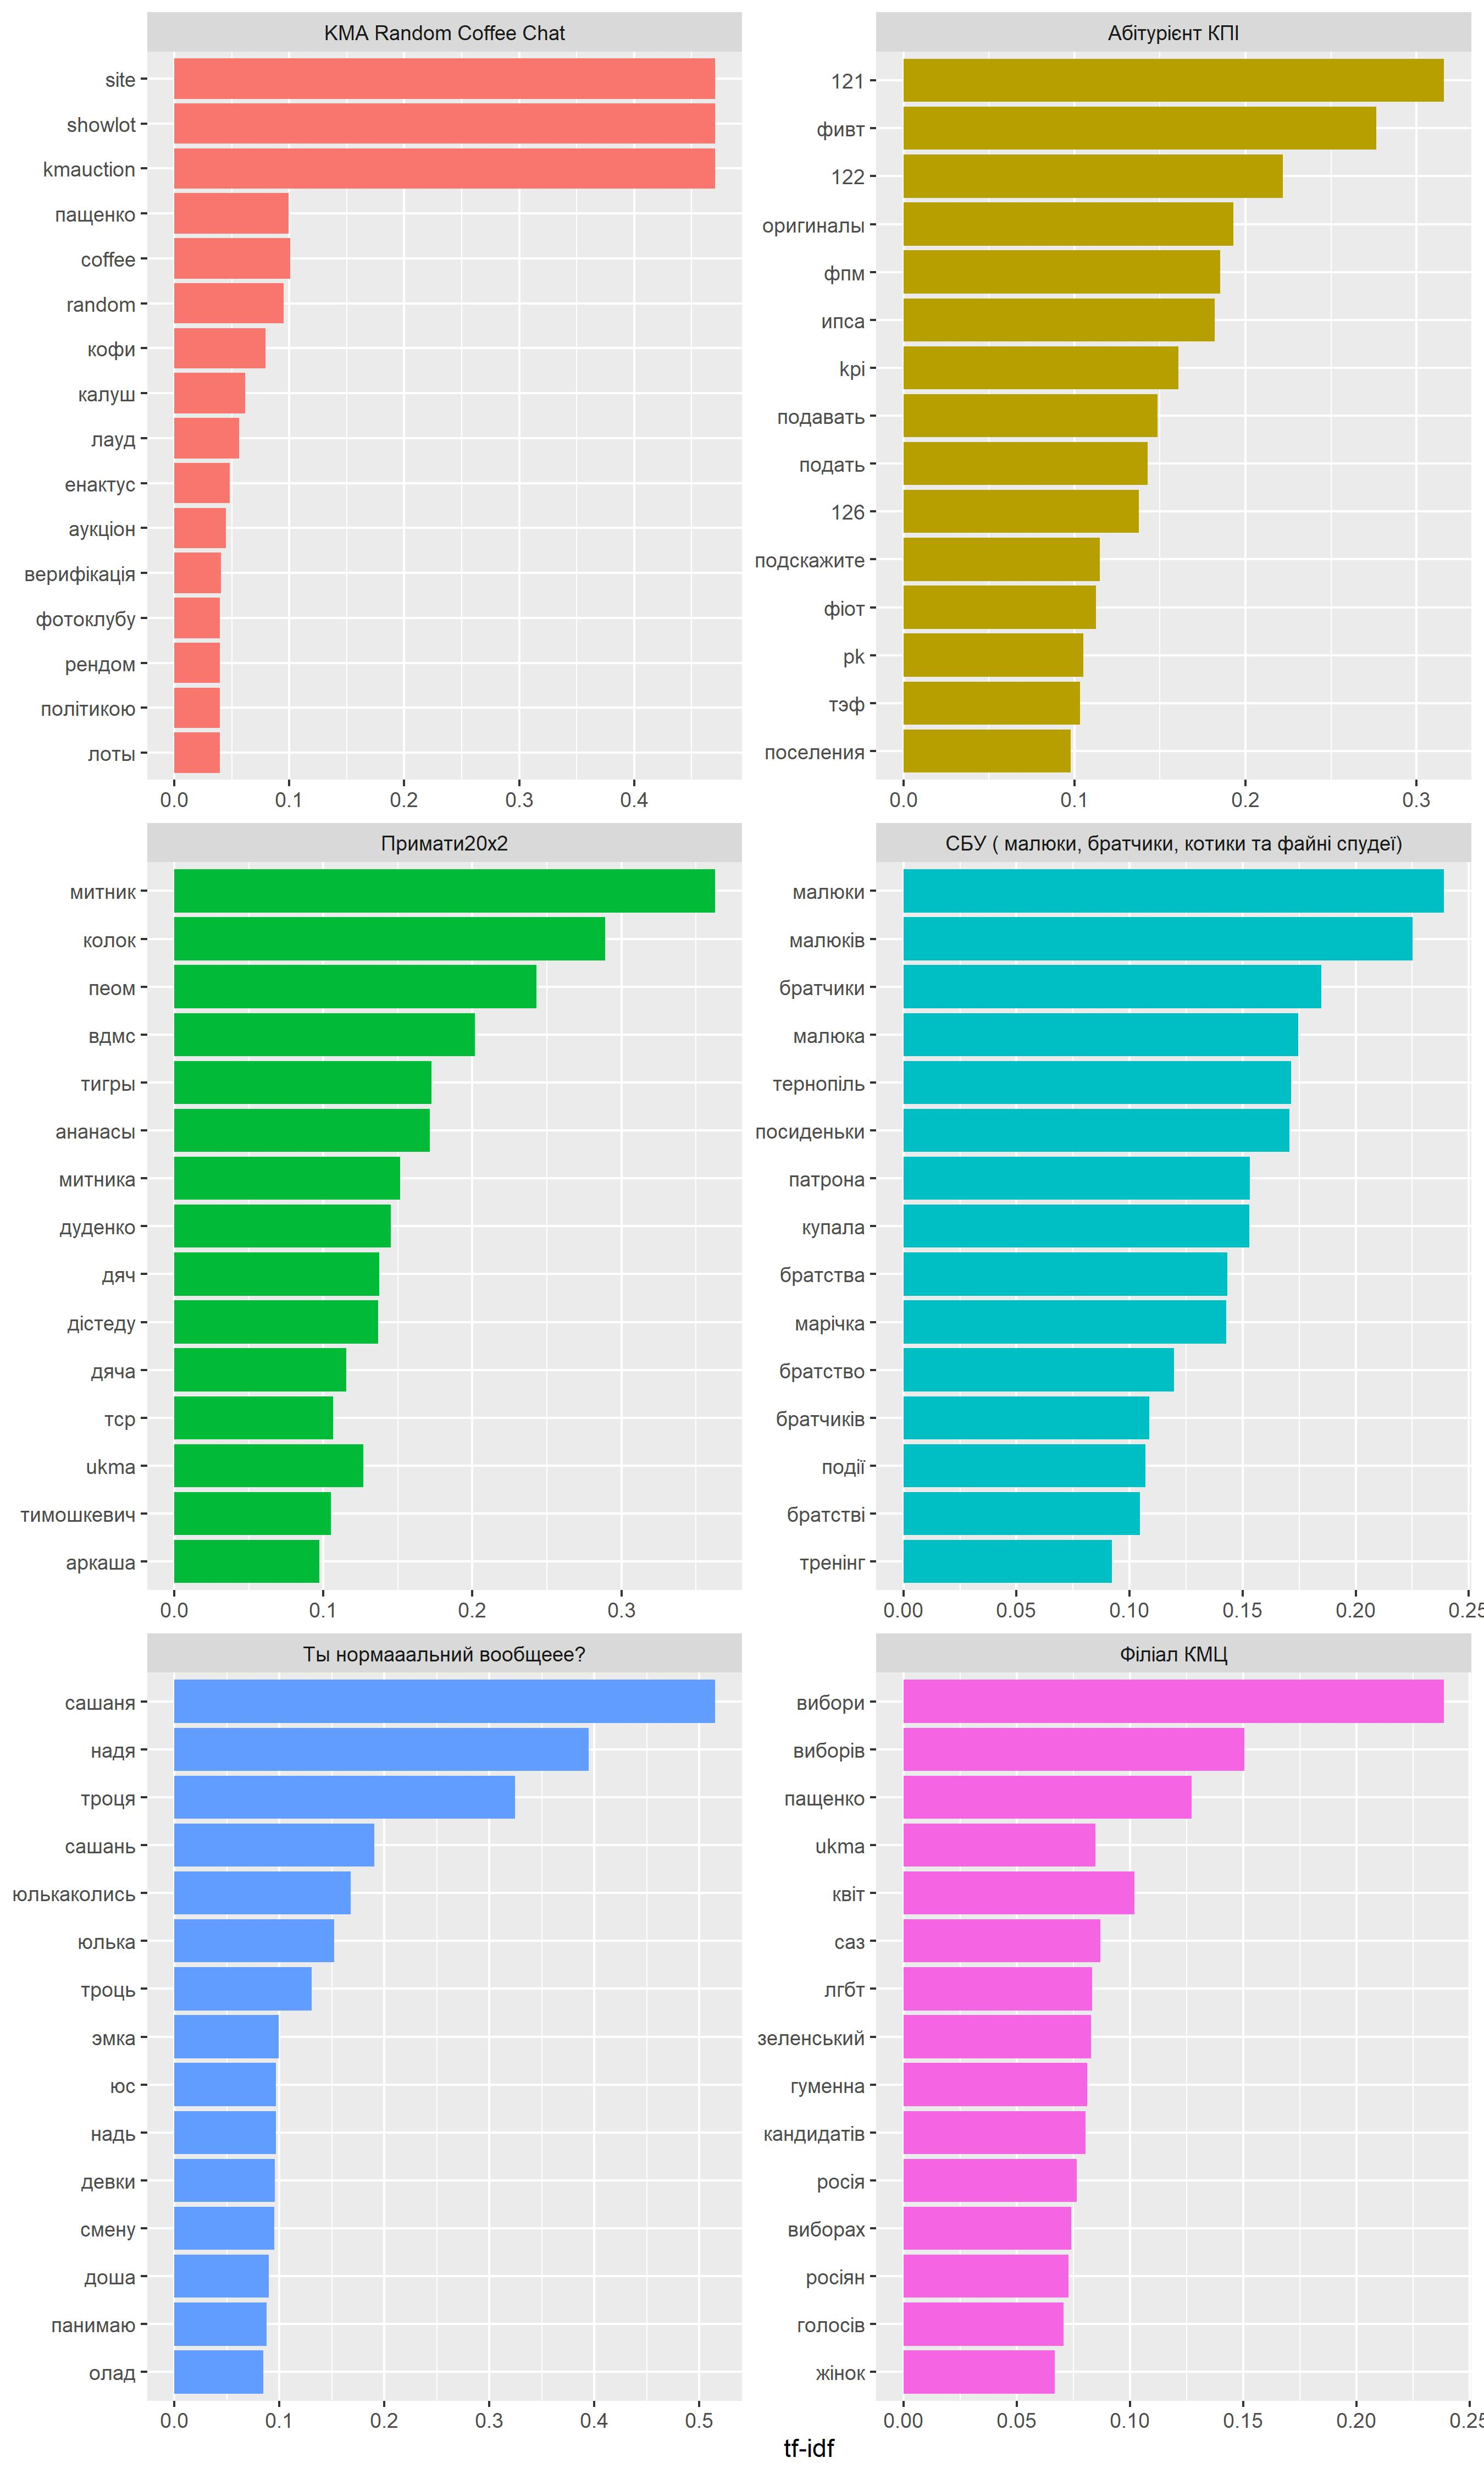



## 5. Average message lenght/amount of members in a group

In [92]:
all_groups=df_all[df_all["dialog_type"]=="Group"]
size=df_meta[df_meta["type"]=="Group"].groupby([ "name"]).size().sort_values(ascending=False).reset_index(name='size')


In [93]:
all_groups_stat=all_groups.groupby("name").agg(msg_amount=('message', 'size'), avg_msg_len=('msg_len', 'mean')).reset_index()


In [155]:
all_groups_stat['avg_msg_len']=all_groups_stat['avg_msg_len'].astype(int)
size['size']=size['size'].astype(int)

display(all_groups_stat)




,name,msg_amount,avg_msg_len,size
78,Філіал КМЦ,100000,55,2754
14,Абітурієнт КПІ,90168,46,1216
4,KIEV KUTËJ KLAN 🍭,72520,14,1097
7,The School & Co,100000,30,658
97,🎄Математика ЗНО 2022🎄,100000,22,589
...,...,...,...,...
60,Подарок нада,21,13,3
99,🐶,301,7,3
69,Сильні і незалежні,1812,18,2
39,Италия,181,27,2


In [95]:
all_groups_stat=pd.merge(all_groups_stat, size, left_on=['name'], right_on=['name'])

In [ ]:
all_groups_stat=all_groups_stat.sort_values("size", ascending=False)
all_groups_stat_clean = all_groups_stat.drop(all_groups_stat[(all_groups_stat.avg_msg_len > 60)| (all_groups_stat.avg_msg_len < 10) | (all_groups_stat.msg_amount < 200)].index)
all_groups_stat_clean['size']=all_groups_stat_clean['size'].astype(int)


In [158]:
%%R -i all_groups_stat_clean
library(ggplot2)
library(hrbrthemes)
library(ggthemes)

 ggplot(all_groups_stat_clean, aes(x=size, y=avg_msg_len)) +
  geom_point() +
  geom_smooth( method = 'loess', formula=y ~ x, color="red", fill="#69b3a2", se=TRUE) +
  theme_ipsum()+
  labs(x='Size of the group', y="Average length of message in a group") + 
    scale_x_continuous( trans='log10')+ 
    labs(title = "Distribution between size of group and average lenght of message in it") +
  theme_gray(base_size = 20 )+theme(plot.title = element_text(size = 22, face = "bold"))
#      theme_wsj()+ scale_colour_wsj("colors6")+
                # Axis titles
ggsave("rplot3.png", width = 12, height = 10)
 




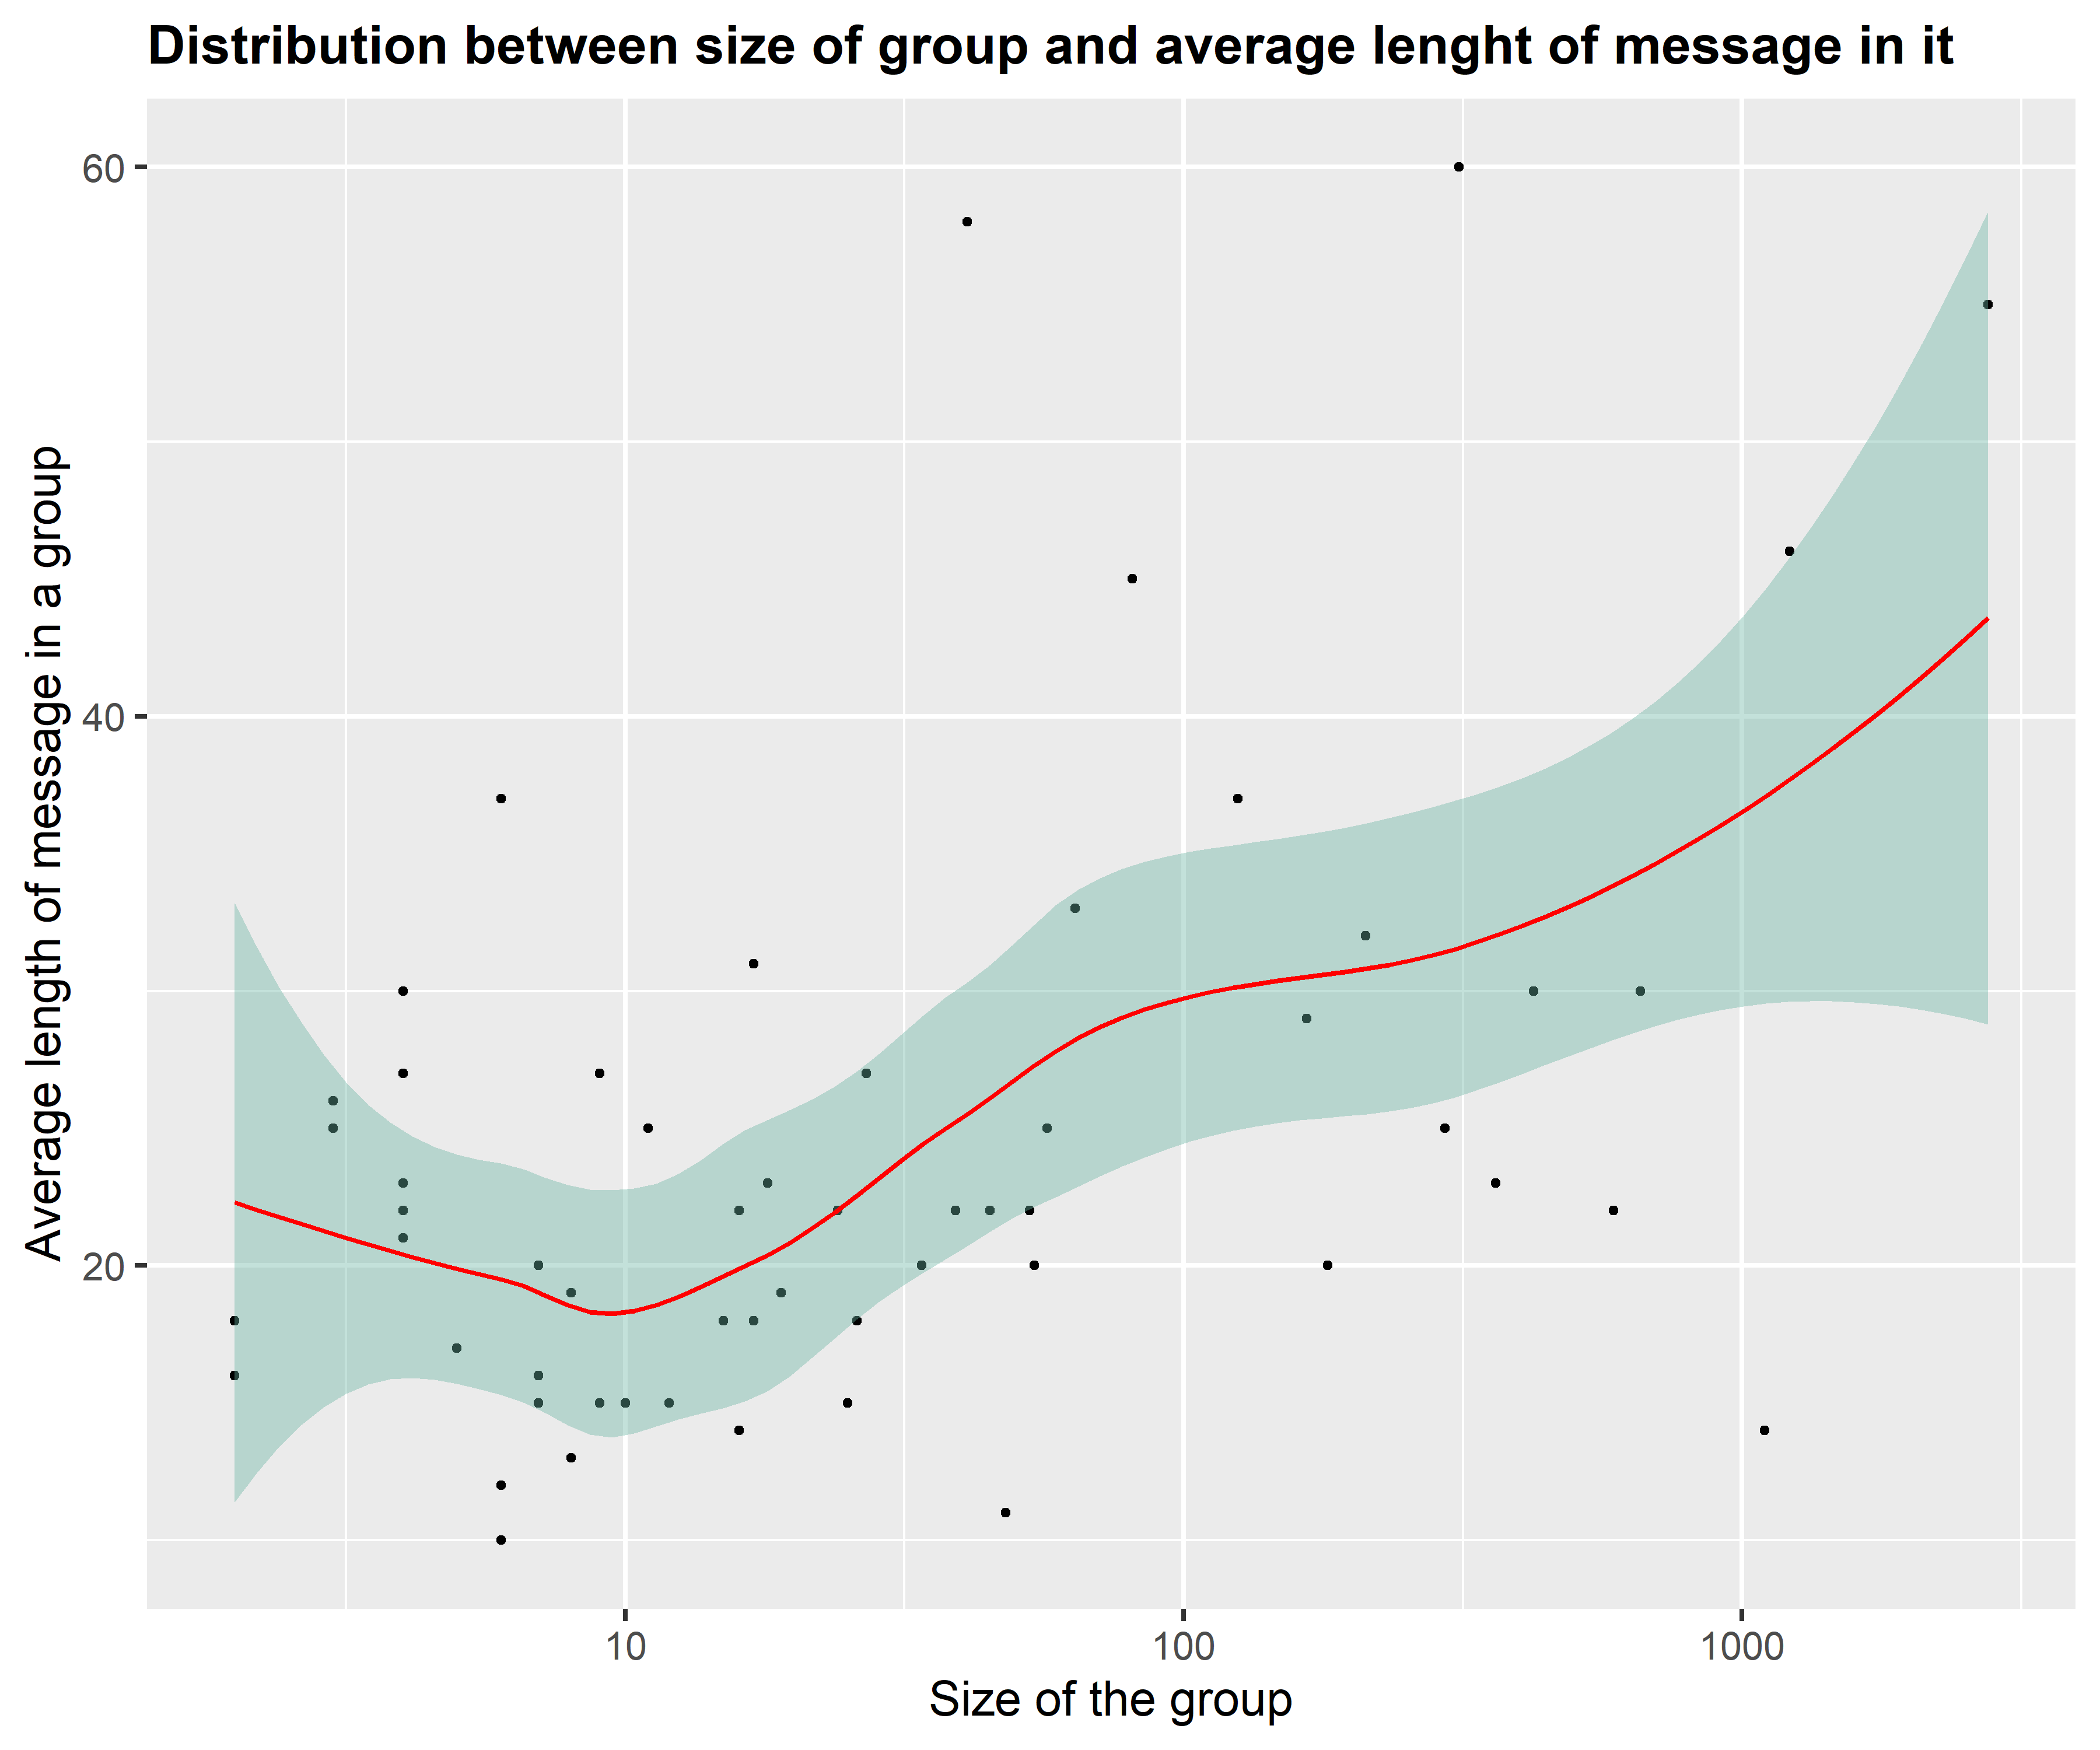

### 5. A bit of analitics in private dialogues

In [108]:

date=pd.to_datetime(datetime.strptime("2021-12-01 00:00:00+00:00", "%Y-%m-%d %H:%M:%S+00:00"))

recent_private=df_all[(df_all['date']>=date.tz_localize('utc')) & (df_all['dialog_type'] =="Private dialog")]

In [110]:
recent_private['date']=recent_private['date'].apply(lambda x: x.date())


C:\Users\Dasha\anaconda3\envs\myrandpy\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
pp=recent_private.groupby(["dialog_id", "date"]).apply(lambda x: x[(x['mes_type']=='video' )& (x['from_id'].str.contains('395158213'))]['dialog_id'].count()).reset_index()


In [113]:
new=pp.groupby("dialog_id").agg(num_of_days=('date', 'count'), video_avg=(0, 'mean'), video_sum=(0, 'sum')).reset_index()


In [114]:
new=new.sort_values(by=['video_avg'], ascending=False)
new

,dialog_id,num_of_days,video_avg,video_sum
34,470333181,70,4.585714,321
20,381343716,81,4.345679,352
4,270465128,46,1.608696,74
86,5090228491,2,1.500000,3
79,1610556588,77,1.441558,111
...,...,...,...,...
32,461536538,1,0.000000,0
31,459802765,4,0.000000,0
29,430091003,8,0.000000,0
28,429153241,1,0.000000,0


In [115]:
new.dialog_id=new.dialog_id.astype(str)

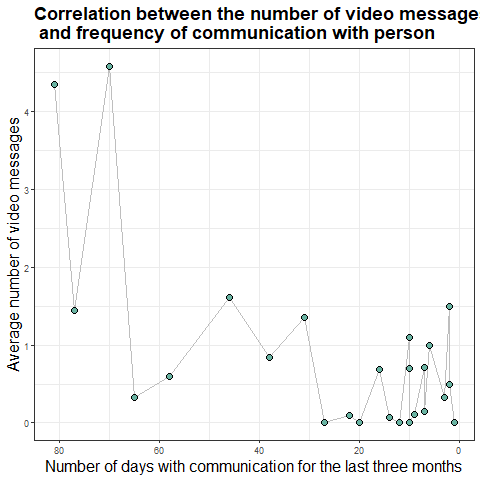

In [154]:
%%R -i new
library(ggplot2)
library(dplyr)
library(hrbrthemes)

f <- new %>%
  head(30) %>%
  ggplot( aes(x=num_of_days, y=video_avg)) +
    geom_line( color="grey") +
    geom_point(shape=21, color="black", fill="#69b3a2", size=3) +
    ggtitle("Evolution of bitcoin price") +
    labs(x='Number of days with communication for the last three months', y="Average number of video messages", title = "Correlation between the number of video messages\n and frequency of communication with person") +
   theme_bw()+theme(plot.title = element_text(size = 18, face = "bold"), axis.title=element_text(size = 16))+scale_x_reverse()
ggsave("video.png", width = 6, height = 8)

print(f)


## 6. word usage frequency

In [121]:
wf=onlytext
wf['date']=wf['date'].apply(lambda x: pd.to_datetime(x).date())


In [122]:
wf['message']=wf['message'].apply(lambda x: str(x))

In [132]:
af=wf.groupby('date')['message'].agg([ ' '.join]).reset_index()


In [133]:
display(af)

,date,join
0,2015-09-22,nan
1,2015-09-24,#КПИдень\n\n24 сентября. Два воскрешения и мно...
2,2015-09-25,"#КПИдень\n\n25 сентября. Пятница, продолжение ..."
3,2015-09-26,"#КПИдень\n\n26 сеньтября. 248 750, день контра..."
4,2015-09-27,#КПИдень\n\n27 сентября. ИССЗИ и контр-кпишный...
...,...,...
2096,2022-02-16,"И теперь такой вопрос вам, друзья. Первая вчер..."
2097,2022-02-17,Еще более простой вопрос. Почему штурманство -...
2098,2022-02-18,Вот еще задача. Девушка пригласила знакомого м...
2099,2022-02-19,Как не надо просить помощи? Нельзя упрекать и ...


In [134]:
af['корона'] = af['join'].apply(lambda x: x.lower().count("корона"))
af['україна'] = af['join'].apply(lambda x: x.lower().count("україна"))
af['русня'] = af['join'].apply(lambda x: x.lower().count("русн"))
af['ядерка'] = af['join'].apply(lambda x: x.lower().count("ядер"))
af['війна'] = af['join'].apply(lambda x: x.lower().count("війна"))


In [135]:
af['путін'] = af['join'].apply(lambda x: x.lower().count("путін"))
af['дедлайн'] = af['join'].apply(lambda x: x.lower().count("дедлайн"))
af['вибори'] = af['join'].apply(lambda x: x.lower().count("вибори"))


In [136]:
af["date"] = pd.to_datetime(af["date"])
af=af.set_index('date')



In [137]:
mew=af.resample('M').sum().reset_index()
mew=mew.set_index('date')

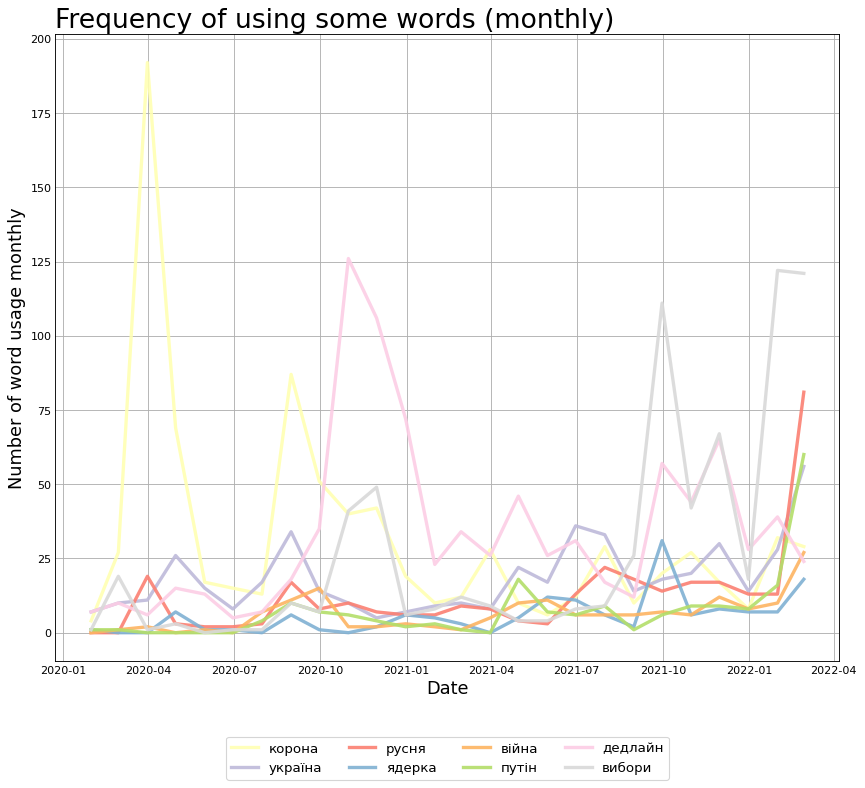

In [160]:

# Make a data frame
last_year= mew['2020-01-01' :]
last_year=last_year.reset_index()

from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
# Change the style of plot
plt.style.use( 'seaborn-pastel')
 
# Create a color palette
palette = plt.get_cmap('Set3')
 
# Plot multiple lines
num=0
for column in last_year.drop(['date'], axis=1):
    num+=1
    plt.plot(last_year['date'], last_year[column], marker='', color=palette(num), linewidth=3, alpha=0.9, label=column)

# Add legend
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -.2), prop={"size":12})

 
# Add titles
plt.title("Frequency of using some words (monthly)", loc='left', fontsize=24, fontweight=0)
plt.ylabel("Number of word usage monthly" , fontsize=16)
plt.xlabel("Date",  fontsize=16)

# Show the graph
plt.show()

### Questions I would like to answer: 

1. How the length and number of voice messages depend on gender.
2. Splash of messages in chats and why?
4. Analysis of personal chats with Mohyla students. Communicating with people throughout the year / during the session period. What percentage writes only during exams?
5. The ratio of Ukrainian to Russian in groups, in personal chats. How has the number of Ukrainian language changed over time and over the years?
6. Language in private dialogues. What language do people answer when writing in Ukrainian? Number of Ukrainian-language, English-language and Russian-language dialogues.
7. How many Mohyla residents are Russian-speaking / Ukrainian-speaking
8. Length of messages in the group / number of participants in it 
10. Which words became popular and which ceased to be used.
11.  Typical Mohyla words and frequency of their use.
12. Active users in groups, whether they are equally active in other chats.
13. Top 10 most active people at the university 
14. Count connected people through joint groups
15. Frequency of using stickers during the day (for personal dialogues).
16. What type of message most often starts a conversation, how it ends. Which words are the most popular for it.
17. In what period of year the largest number of photos and media is sent.
18. Average length of text messages and frequency of their use. Changes in performance over time.
19. The average number of types of messages per day. Research of the night period.
20. length of voice and text messages depending on the time of day.
21. How weekends affect the activity in the telegram. We take statistics on weekday evenings and weekends (Friday and Saturday). The average number of each type of message.
22. 2019/2020. Changing the statistics of messages due to the covid pandemic.
23. Statistics of joining new users in telegrams. Dependence on the scandal about WhatsApp.
24. The most active hours for correspondence depending on the season.
25. The average length of text messages sent by each person. Have messages shrunk over time?
26. How much time is spent on correspondence with each person on average per day (the success of the conversation, its productivity) and what it depends on. We equate the success of a conversation to the number of messages per day. Correlations between the length of messages, the frequency of sending, the use of voice, who started the conversation.
27. Average response time, correlation with the degree of closeness of the person.
28. Dependence of the number of video messages on the degree of closeness.
29. Links to which resources are most popular.
33. Who usually starts the conversation 